# QCodes and helpers

In [1]:
import numpy as np
import qcodes

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class BufferParameter(qcodes.Parameter):
    def set_raw(self, v):
        self.value = v
    def get_raw(self):
        return getattr(self, 'value', None)

In [ ]:
# Tektronix DPO70000 8GHz oscilloscope
from qcodes.instrument_drivers.tektronix.DPO70000 import Tektronix_DPO70000
Tektronix_DPO70000.close_all()
osc = Tektronix_DPO70000('oscilloscope', 'TCPIP::192.168.1.200::INSTR')

# Snaphot

Create a snapshot of all parameters to make sure all get_cmd are supported by the device. 

In [4]:
# watch out for warning messages here
snap = osc.snapshot(update=True)

In [5]:
# pretty-print instrument parameters
parameters = {}
for k, p in snap['parameters'].items():
    if k == 'IDN':
        continue
    parameters[k] = p['value']
for mod_k, mod in snap['submodules'].items():
    parameters[mod_k] = dict((k, p['value']) for k, p in mod['parameters'].items() if 'value' in p)
    
display(parameters)

{'timeout': 5.0,
 'acq_state': True,
 'acq_single': False,
 'acq_mode': 'sample',
 'acq_numacq': 1869150,
 'acq_fast': False,
 'acq_averages': 100,
 'acq_envelopes': 1000,
 'acq_wfmdbs': 65536000,
 'acq_sampling': 'equivalent',
 'hmode': 'auto',
 'hscale': 1e-08,
 'samplerate': 12500000000.0,
 'recordlength': 1250,
 'hposition': 75.6,
 'hdelay_status': False,
 'hdelay_pos': 50.0,
 'hdelay_time': 1e-06,
 'frame_state': True,
 'frame_count': 51,
 'frame_maxcount': 18492,
 'frame_seqstop': 'single',
 'frame_numacq': 1869048,
 'frame_sumframe': 'none',
 'triggerA': {'level': 1.034,
  'type': 'edge',
  'ready': False,
  'mode': 'normal',
  'holdoff_type': 'time',
  'holdoff_time': 1e-06,
  'edge_coupling': 'dc',
  'edge_slope': 'rising',
  'edge_source': 'aux'},
 'triggerB': {'level': 1.034,
  'type': 'edge',
  'ready': False,
  'state': False,
  'by': 'events',
  'events': 54,
  'time': 3.2e-09,
  'edge_coupling': 'dc',
  'edge_slope': 'rising',
  'edge_source': 'aux'},
 'ch1': {'state': F

# Control flow

In [6]:
# start acquisition in run/stop mode
osc.run()

In [7]:
# stop acquisition
osc.stop()

In [8]:
# start acquisition in single mode and (optionally) wait for the acquisition to finish
osc.single()

True

In [9]:
# wait for acquisition to stop. must be started and in single mode or manually stopped.
osc.wait(timeout=5)

True

# Trigger setup

The only trigger modes implemented are edge triggers and A$\rightarrow$B trigger sequences.

In [10]:
# configure edge trigger on aux
osc.triggerA.mode('normal')
osc.triggerA.holdoff_type('default')
osc.triggerA.type('edge')
osc.triggerA.edge_source('aux')
osc.triggerA.edge_slope('rising')
osc.triggerA.autoset()
osc.triggerB.state(False)
'trigger level is {}V'.format(osc.triggerA.level())

'trigger level is 1.045V'

In [18]:
# trigger holdoff
osc.triggerA.holdoff_type('time')
osc.triggerA.holdoff_time(1e-6)

In [19]:
# test trigger coupling val_mapping
osc.triggerA.edge_source('ch1')
for key in osc.triggerA.edge_coupling.val_mapping:
    osc.triggerA.edge_coupling.set(key)
    assert key == osc.triggerA.edge_coupling.get()

In [20]:
# test trigger slope val_mapping
for key in osc.triggerA.edge_slope.val_mapping:
    osc.triggerA.edge_slope.set(key)
    assert key == osc.triggerA.edge_slope.get()

In [21]:
# A-B trigger: sequence start on ch1, shot trigger on aux
osc.triggerA.edge_source('ch1')
osc.triggerA.autoset()
osc.triggerB.edge_source('aux')
osc.triggerB.autoset()
osc.triggerB.by('events')
osc.triggerB.events(20)
osc.triggerB.state(True)
'A trigger level is {}V, B trigger level is {}V'.format(osc.triggerA.level(), osc.triggerB.level())

'A trigger level is 0.396V, B trigger level is 1.037V'

# Horizontal setup

In [22]:
# horizontal mode auto: set hscale only
osc.hmode('auto')
osc.samplerate(2.5e9) # ignored
osc.hscale(100e-9)
print('{} samples at {:f}GS/s, {}ns/div'.format(osc.recordlength(), osc.samplerate()/1e9, osc.hscale()*1e9))

12500 samples at 12.500000GS/s, 100.0ns/div


In [23]:
# horizontal mode constant: set sample rate and hscale
osc.hmode('constant')
osc.samplerate(2.5e9)
osc.recordlength(2000) # ignored
osc.hscale(100e-9)
print('{} samples at {:f}GS/s, {}ns/div'.format(osc.recordlength(), osc.samplerate()/1e9, osc.hscale()*1e9))

3125 samples at 3.125000GS/s, 100.0ns/div


In [24]:
# horizontal mode manual: set sample rate and record length
osc.hmode('manual')
osc.samplerate(2.5e9)
osc.recordlength(2000)
osc.hscale(100e-9) # ignored
print('{} samples at {:f}GS/s, {}ns/div'.format(osc.recordlength(), osc.samplerate()/1e9, osc.hscale()*1e9))

2000 samples at 3.125000GS/s, 64.0ns/div


In [25]:
# delay trigger
osc.hdelay_status(True)
osc.hdelay_time(1e-6)
#osc.hdelay_status(False)

# Vertical setup

## Analog channel

In [5]:
channel = osc.ch2
channel.show()

In [12]:
channel.coupling.set('dc')
channel.termination.set(50)
channel.bandwidth.set(1e9)
channel.deskew.set(0.)

In [13]:
channel.vscale.set(100e-3)
channel.vposition.set(0.)
channel.offset.set(0.)

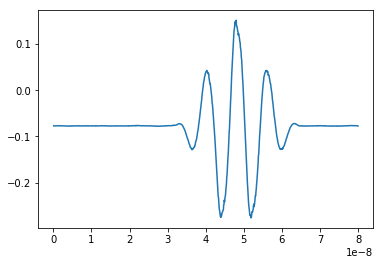

In [19]:
osc.acq_mode('sample')
osc.frame_state(False)
osc.run()

data, setpoints = channel.curve.get(), channel.curve.setpoints
plt.plot(setpoints[-1].T, data.T);

## Math channel

In [20]:
math = osc.math1
math.show()

In [21]:
math.expression.set('AVG(Ch2*Ch2)')
math.averages.set(10)

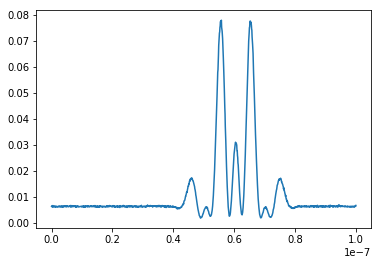

In [22]:
osc.acq_mode('sample')
osc.frame_state(False)
osc.run()

data, setpoints = math.curve.get(), math.curve.setpoints
plt.plot(setpoints[-1].T, data.T);

# Acquisition modes

Acquiring trace and pixmap(histogram) data from the instrument is via the
channel.curve, channel.curvenext, channel.pixmap and channel.pixmapnext array parameters.

* curve transfers one or more traces from the waveform memory
 * output is 1d in all modes except fast frame
 * wfmdb and fastacq modes acquire a histogram, curve returns <Y(t)>
 * multiple calls to curvenext.get() return non-overlapping data sets in run/stop mode
* pixmap transfers 2d histograms in wfmdb and fastacq modes
 * multiple calls to pixmapnext.get() return non-overlapping data sets in run/stop mode
 
In the below examples, the oscilloscope is connected to an awg programmed with Gaussian microwave pulses of amplitudes linspace(0, 1, 51). The oscilloscope receives a marker on the AUX input when the AWG starts outputting a waveform and a marker on CH1 when the first awg segment is played. To spice it up, the awg trigger pulse is tuned such that the awg trigger jitters.

In [23]:
# set 10ns/div with automatic record length and sample rates, measure in run/stop mode
osc.hmode('auto')
osc.hscale(10e-9)
osc.run()

In [24]:
# disable fast acquisitions and fast frame
osc.acq_fast(False)
osc.frame_state(False)

## Sample mode

In [25]:
osc.acq_mode('sample')

In [26]:
channel.curve.prepare()
data = qcodes.Measure(channel.curve).run()

DataSet:
   location = 'data/2018-05-17/#028_{name}_17-26-31'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Measured | oscilloscope_ch2_curve | curve        | (1250,)
acquired at 2018-05-17 17:26:31


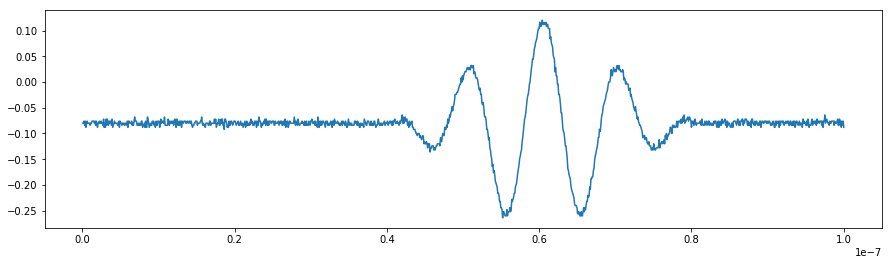

In [27]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(data.arrays['X_set'], data.arrays[channel.curve.full_name]);

## peakdetect mode

In [28]:
osc.acq_mode('peakdetect')

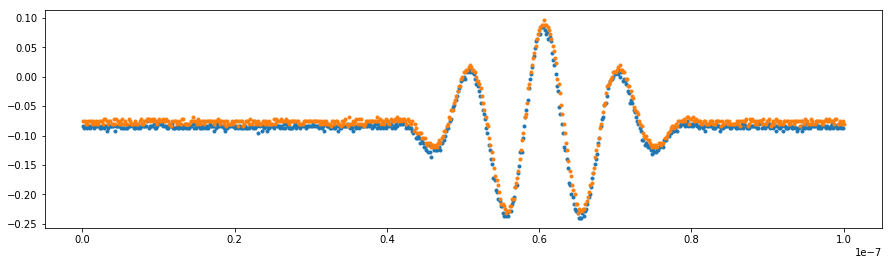

In [29]:
data = channel.curve.get()
xs = channel.curve.setpoints[0]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs[::2], data[::2], '.');
ax.plot(xs[1::2], data[1::2], '.');

## hi-res mode

In [30]:
osc.acq_mode('hires')

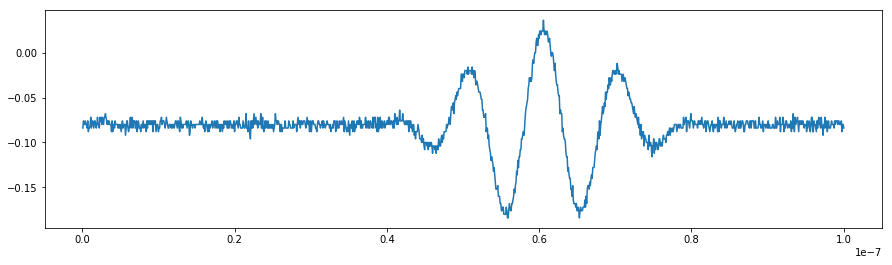

In [31]:
data = channel.curve.get()
xs = channel.curve.setpoints[0]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs, data);

## average mode

In [32]:
osc.acq_mode('average')
osc.acq_averages(10)

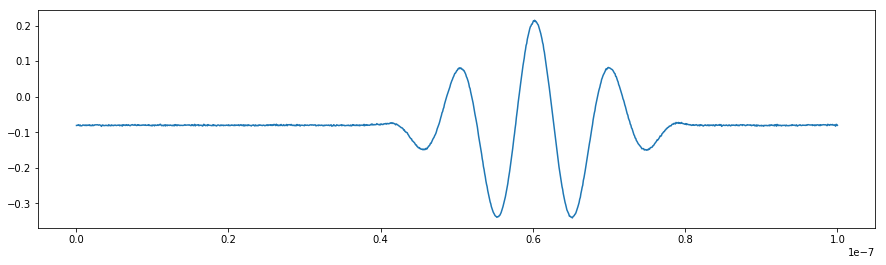

In [33]:
data = channel.curve.get()
xs = channel.curve.setpoints[0]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs, data);

In [34]:
# measure independent traces with curvenext
# may run into timeouts if the acquisition time is too long
osc.run()
channel.curvenext.prepare()
data = (
    qcodes
    .Loop(BufferParameter('iteration').sweep(0, 10, 1))
    .each(channel.curvenext)
).run()

Started at 2018-05-17 17:26:42
DataSet:
   location = 'data/2018-05-17/#029_{name}_17-26-42'
   <Type>   | <array_id>                 | <array.name> | <array.shape>
   Setpoint | iteration_set              | iteration    | (11,)
   Measured | oscilloscope_ch2_curvenext | curvenext    | (11, 1250)
Finished at 2018-05-17 17:26:43


In [36]:
# measure independent traces with single shot acquisition
channel.curve.prepare()
data = (
    qcodes
    .Loop(BufferParameter('iteration').sweep(0, 10, 1))
    .each(qcodes.Task(osc.single),
          channel.curve)
).run()
osc.run()

Started at 2018-05-17 17:26:49
DataSet:
   location = 'data/2018-05-17/#030_{name}_17-26-49'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Setpoint | iteration_set          | iteration    | (11,)
   Measured | oscilloscope_ch2_curve | curve        | (11, 1250)
Finished at 2018-05-17 17:26:51


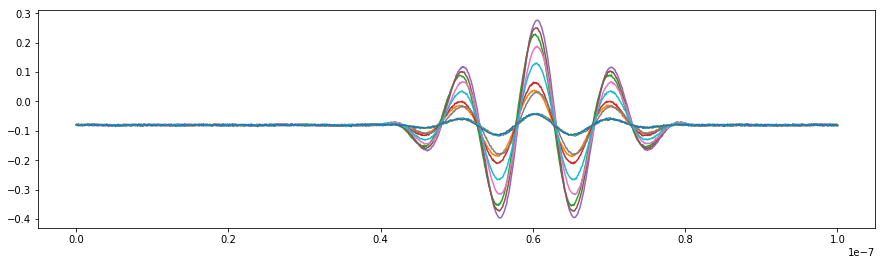

In [37]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(data.arrays['X_set'].T, data.arrays[channel.curve.full_name].T);

## envelope mode

In [38]:
osc.acq_mode('envelope')
osc.acq_envelopes(1000)

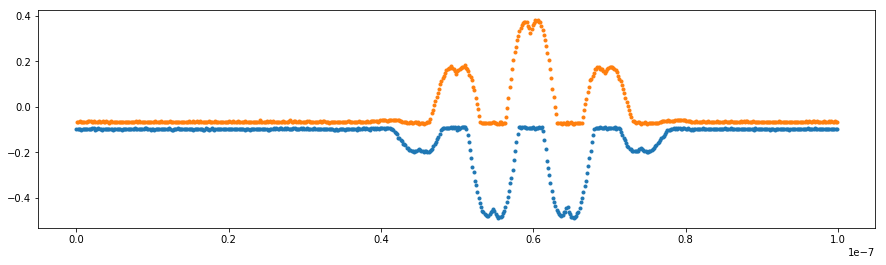

In [39]:
data = channel.curve.get()
xs = channel.curve.setpoints[0]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs[::2], data[::2], '.')
ax.plot(xs[1::2], data[1::2], '.')

## wfmdb mode

In [40]:
osc.acq_mode('wfmdb')
# according to the manual, the max is 214,740,000 (17.5bit)
osc.acq_wfmdbs((1<<16)*1000)
osc.acq_wfmdbs()

65536000

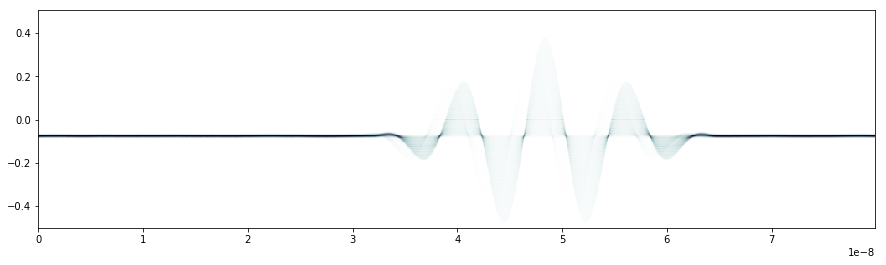

In [41]:
# retrieve histogram counts
pixmap = channel.pixmap.get()
setpoints = channel.pixmap.setpoints
xs, ys = np.broadcast_arrays(setpoints[0][:,None], setpoints[1])
fig, ax = plt.subplots(figsize=(15,4))
ax.pcolormesh(xs, ys, pixmap, cmap='bone_r')

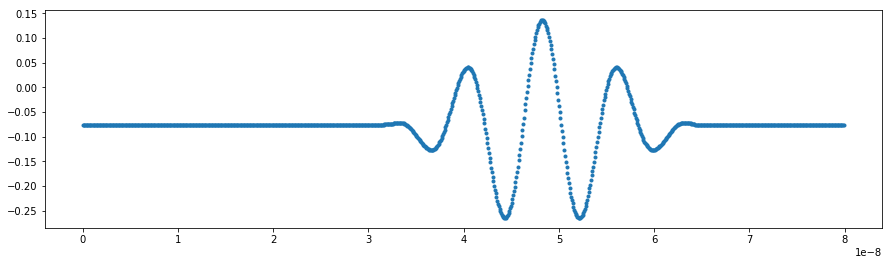

In [42]:
# retrieve mean of the histogram
data = channel.curve.get()
xs = channel.curve.setpoints[0]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs, data, '.')

## FastACQ mode

In [43]:
osc.acq_fast(True)
osc.acq_wfmdbs((1<<16)*1000)
osc.acq_mode()

'sample'

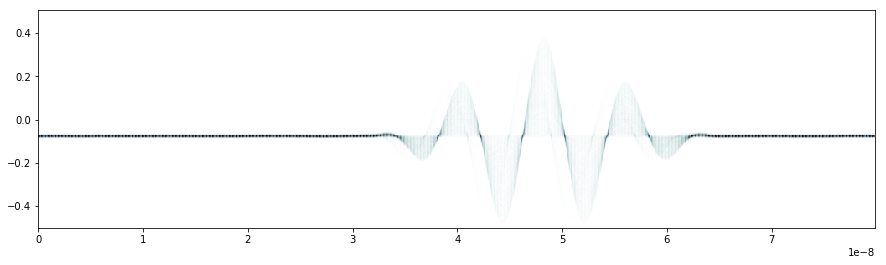

In [44]:
# retrieve histogram counts
pixmap = channel.pixmap.get()
setpoints = channel.pixmap.setpoints
xs, ys = np.broadcast_arrays(setpoints[0][:,None], setpoints[1])
fig, ax = plt.subplots(figsize=(15,4))
ax.pcolormesh(xs, ys, pixmap, cmap='bone_r')

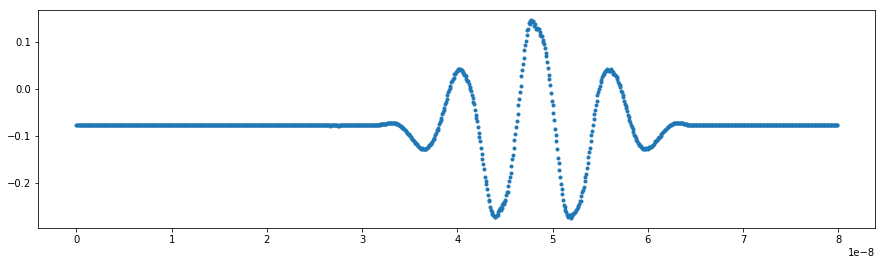

In [45]:
# retrieve mean of the histogram
data = channel.curve.get()
xs = channel.curve.setpoints[0]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs, data, '.');

## Fast frame averaged acquisition

use fast frame mode to acquire 256 curves and have the oscilloscope calculate the mean

In [6]:
osc.frame_state(True)
osc.frame_count(257)
# retrieve only frame #257, which contains the mean
osc.frame_sumframe('average')
channel.curve.prepare(frame_start=257, frame_stop=257)

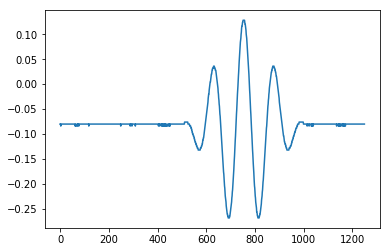

In [14]:
plt.plot(data.T)

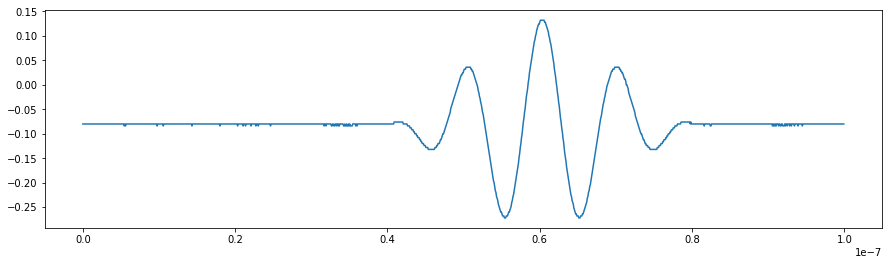

In [18]:
data = channel.curve.get()
xs = channel.curve.setpoints[-1]
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xs[0], data[0]);

## Fast frame sequence acquisition

In [19]:
osc.frame_state(True)
osc.frame_count(51)
osc.frame_sumframe('none')
# retrieve all frames from the instrument
channel.curve.prepare()

In [20]:
# A only trigger
osc.triggerA.edge_source('aux')
osc.triggerA.autoset()
osc.triggerB.state(False)

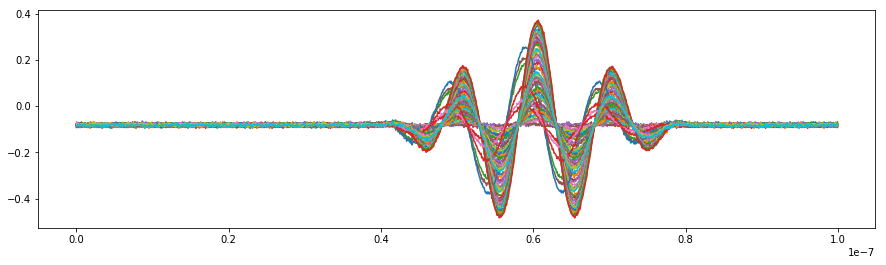

In [21]:
data = channel.curve.get()
xss = channel.curve.setpoints[1]
fig, ax = plt.subplots(figsize=(15,4))
for xs, trace in zip(xss, data):
    ax.plot(xs, trace)

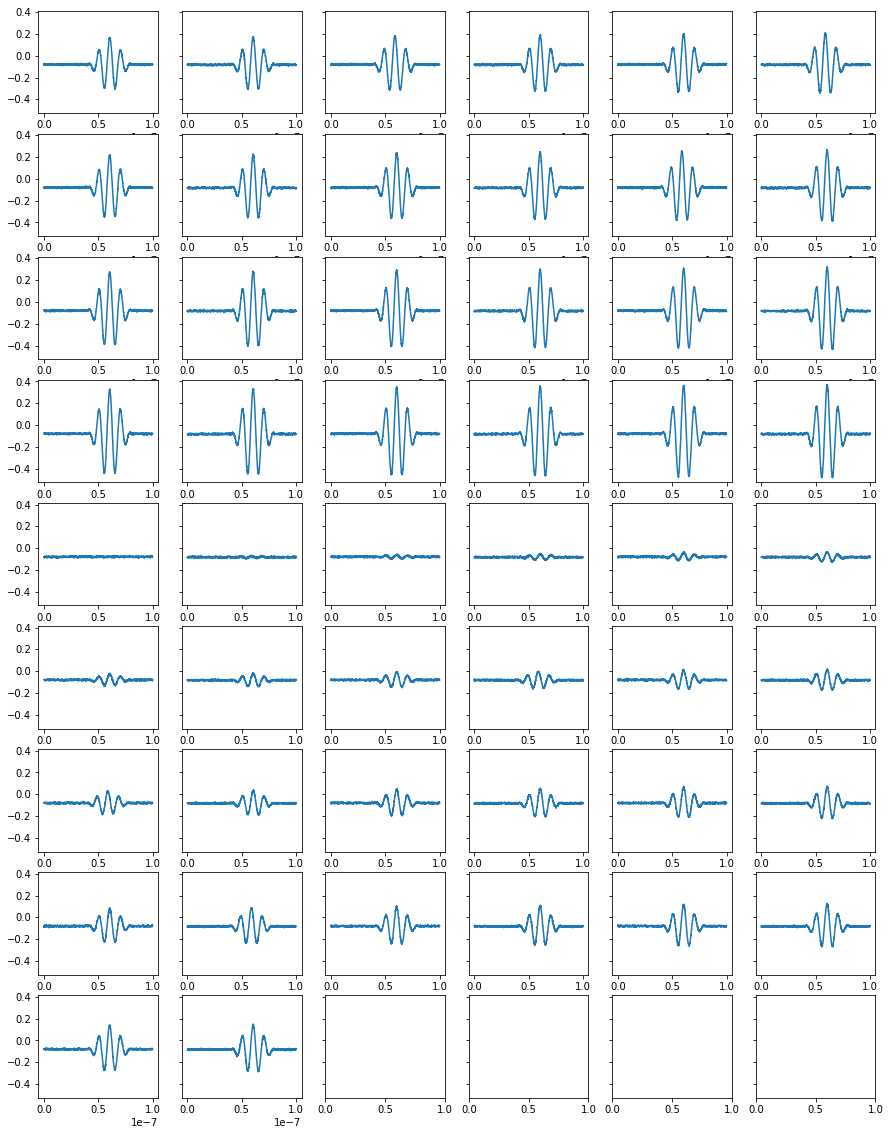

In [22]:
fig, axes = plt.subplots(9, 6, figsize=(15,20), sharey=True)
for ax, xs, ys in zip(axes.ravel(), channel.curve.setpoints[1], data):
    ax.plot(xs, ys);

## A$\rightarrow$B sequence acquisition

In [23]:
osc.frame_state(False)
osc.acq_mode('average')
osc.acq_averages(100)

In [24]:
# A-B trigger: sequence start on ch1, shot trigger on aux
# slower than above because we are discarding most shot triggers, 
# but segment numbers match the awg program
osc.triggerA.edge_source('ch1')
osc.triggerA.autoset()
osc.triggerB.edge_source('aux')
osc.triggerB.autoset()
osc.triggerB.by('events')
osc.triggerB.state(True)

In [25]:
# measure independent traces with single shot acquisition
channel.curvenext.prepare()
osc.run()
data = (
    qcodes
    .Loop(qcodes.SweepFixedValues(osc.triggerB.events, range(1, 55)))
    .each(channel.curvenext)
).run()

Started at 2018-05-17 17:31:55
DataSet:
   location = 'data/2018-05-17/#031_{name}_17-31-55'
   <Type>   | <array_id>                       | <array.name> | <array.shape>
   Setpoint | oscilloscope_triggerB_events_set | events       | (54,)
   Measured | oscilloscope_ch2_curvenext       | curvenext    | (54, 1250)
Finished at 2018-05-17 17:32:34


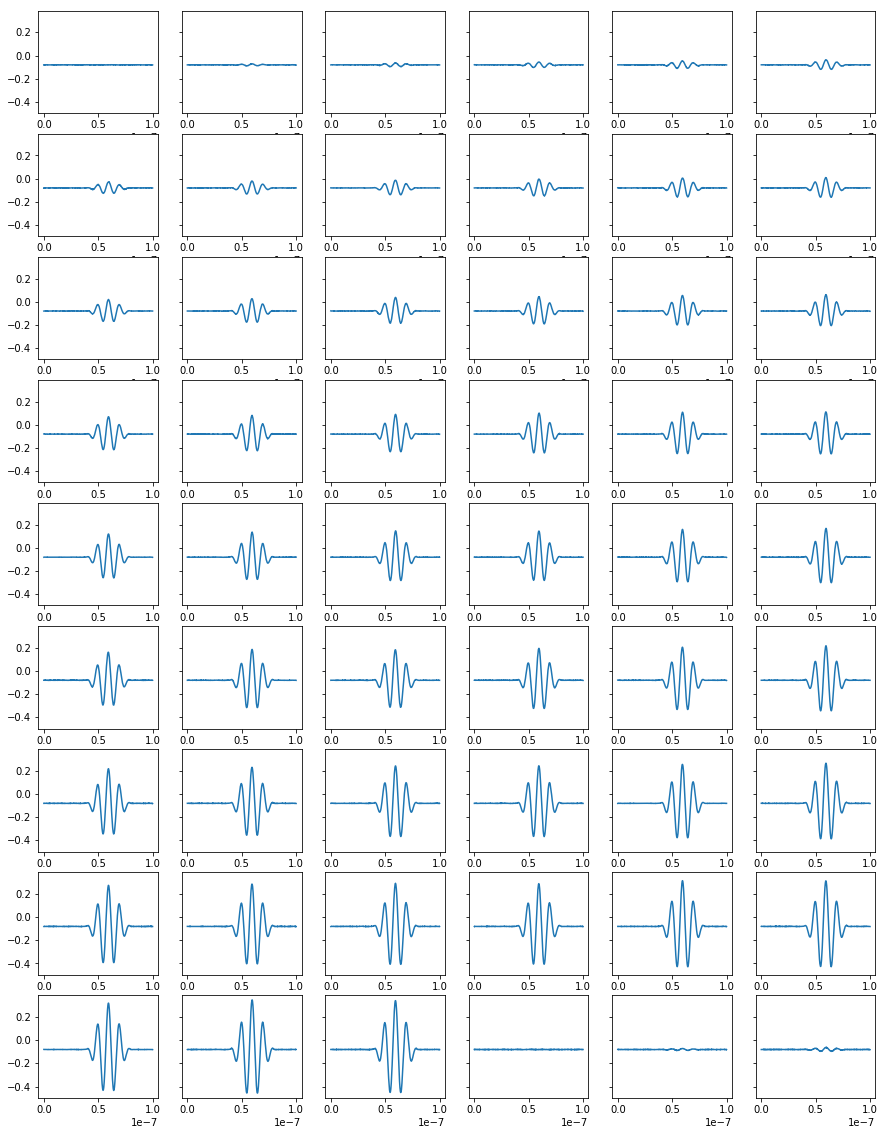

In [26]:
fig, axes = plt.subplots(9, 6, figsize=(15,20), sharey=True)
for ax, xs, ys in zip(axes.ravel(), data.arrays['X_set'], data.arrays[channel.curvenext.full_name]):
    ax.plot(xs, ys);

# Measurements

Not implemented.